# Project Title: GAN for MRI to CT Image Translation

 Step 1: Download and Extract Dataset

In [ ]:
!wget --content-disposition \
"https://zenodo.org/records/7260705/files/Task1.zip?download=1"

!unzip -q Task1.zip -d ./Task1

import os

root_dir = "./Task1/Task1/brain"
print("Sample patient folders:")
print(sorted(os.listdir(root_dir))[:5])


Step 2:Check Dataset Structure and Subject Count

In [ ]:
import os

dataset_path = "/content/Task1/Task1/brain"

# Check if the dataset folder exists and count files
if os.path.isdir(dataset_path):
    file_list = os.listdir(dataset_path)
    print(f"Total files in '{dataset_path}':", len(file_list))
    print("File names:", file_list)
else:
    print("Dataset folder does not exist.")


Total files in '/content/Task1/Task1/brain': 181
File names: ['1BA085', '1BC022', '1BA266', '1BC046', '1BA239', '1BB111', '1BC031', '1BC027', '1BB030', '1BA111', '1BC008', '1BB005', '1BA325', '1BC080', '1BA097', '1BB059', '1BB083', '1BB041', '1BB062', '1BA054', '1BA158', '1BC053', '1BC039', '1BB200', '1BA141', '1BB171', '1BA345', '1BC067', '1BB076', '1BB071', '1BB175', '1BA359', '1BC088', '1BB198', '1BB008', 'overview', '1BC077', '1BA336', '1BB173', '1BA328', '1BB003', '1BB085', '1BC074', '1BC065', '1BB073', '1BB031', '1BC094', '1BC054', '1BC035', '1BA103', '1BC028', '1BA307', '1BC007', '1BA288', '1BB002', '1BC073', '1BA116', '1BC064', '1BC014', '1BB066', '1BA201', '1BC010', '1BC068', '1BC076', '1BC063', '1BB052', '1BA368', '1BA001', '1BC084', '1BA143', '1BA222', '1BA091', '1BC025', '1BC047', '1BA256', '1BB039', '1BA159', '1BB017', '1BA082', '1BC004', '1BB016', '1BA260', '1BA164', '1BC041', '1BC066', '1BB152', '1BC052', '1BA175', '1BA012', '1BA184', '1BB151', '1BB006', '1BA305', '1BC08

Step 3:Split Dataset into Train and Validation Sets

In [ ]:
import random
from shutil import copytree

# Define paths
source_dir = "/content/Task1/Task1/brain"
train_dir = "/content/brain_split/train"
val_dir = "/content/brain_split/val"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List and shuffle patient folders
all_patients = [f for f in os.listdir(source_dir) if f.startswith("1B")]
random.seed(42)
random.shuffle(all_patients)

# Split: 160 for training, 20 for validation
train_patients = all_patients[:160]
val_patients = all_patients[160:180]

# Copy patient folders into train and val directories
for pid in train_patients:
    copytree(os.path.join(source_dir, pid), os.path.join(train_dir, pid))

for pid in val_patients:
    copytree(os.path.join(source_dir, pid), os.path.join(val_dir, pid))

print("Split complete:")
print("Train set:", len(train_patients), "patients")
print("Validation set:", len(val_patients), "patients")


Split complete:
Train set: 160 patients
Validation set: 20 patients


Step 4: Convert 3D MRI & CT to 2D Slices

In [ ]:
import os
import nibabel as nib
import numpy as np
import cv2
from tqdm import tqdm


#Converts image to float
#Returns uint8 image (for saving as PNG)
def normalize(img):
    img = img.astype(np.float32)
    if np.max(img) != np.min(img):  # Avoid divide-by-zero
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
    else:
        img = np.zeros_like(img)
    img *= 255.0
    return img.astype(np.uint8)

#Loads 3D MRI and CT volumes using nibabel
def extract_slices(mri_path, ct_path, prefix, out_mri_dir, out_ct_dir):
    mri_vol = nib.load(mri_path).get_fdata()
    ct_vol = nib.load(ct_path).get_fdata()
    num_slices = min(mri_vol.shape[2], ct_vol.shape[2])

    for i in range(num_slices):
        mri_slice = normalize(mri_vol[:, :, i])
        ct_slice = normalize(ct_vol[:, :, i])

        mri_resized = cv2.resize(mri_slice, (256, 256))
        ct_resized = cv2.resize(ct_slice, (256, 256))

        mri_filename = os.path.join(out_mri_dir, f"{prefix}_slice_{i:03d}.png")
        ct_filename = os.path.join(out_ct_dir, f"{prefix}_slice_{i:03d}.png")
        cv2.imwrite(mri_filename, mri_resized)
        cv2.imwrite(ct_filename, ct_resized)

# Process both train and validation sets
for split in ['train', 'val']:
    input_dir = f"/content/brain_split/{split}"
    output_mri = f"/content/data/{split}/mri"
    output_ct = f"/content/data/{split}/ct"
    os.makedirs(output_mri, exist_ok=True)
    os.makedirs(output_ct, exist_ok=True)

    patients = sorted(os.listdir(input_dir))
    print(f"\nProcessing {split} set: {len(patients)} patients")

    for pid in tqdm(patients):
        patient_path = os.path.join(input_dir, pid)
        mri_path = os.path.join(patient_path, "mr.nii.gz")#for each patient
        ct_path = os.path.join(patient_path, "ct.nii.gz")

        if os.path.exists(mri_path) and os.path.exists(ct_path):
            extract_slices(mri_path, ct_path, pid, output_mri, output_ct)



Processing train set: 160 patients


100%|██████████| 160/160 [03:06<00:00,  1.16s/it]



Processing val set: 20 patients


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


step 5:Preview Extracted MRI Slices (Train & Validation)

In [ ]:
import os

# View training MRI slices
train_mri_path = "/content/data/train/mri"
train_mri_slices = sorted(os.listdir(train_mri_path))
print(" Training MRI slices:", len(train_mri_slices))
print("Sample train MRI files:", train_mri_slices[:5])

# View validation MRI slices
val_mri_path = "/content/data/val/mri"
val_mri_slices = sorted(os.listdir(val_mri_path))
print(" Validation MRI slices:", len(val_mri_slices))
print("Sample val MRI files:", val_mri_slices[:5])


 Training MRI slices: 30674
Sample train MRI files: ['1BA001_slice_000.png', '1BA001_slice_001.png', '1BA001_slice_002.png', '1BA001_slice_003.png', '1BA001_slice_004.png']
 Validation MRI slices: 3885
Sample val MRI files: ['1BA005_slice_000.png', '1BA005_slice_001.png', '1BA005_slice_002.png', '1BA005_slice_003.png', '1BA005_slice_004.png']


step 6:Visualize Sample MRI Slices from Train and Validation Sets

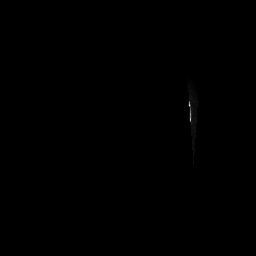

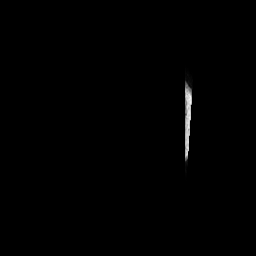

['1BA001_slice_000.png', '1BA001_slice_001.png', '1BA001_slice_002.png', '1BA001_slice_003.png', '1BA001_slice_004.png']


In [ ]:
from IPython.display import display
from PIL import Image as PILImage

# Change to training slice path
img_path = "/content/data/train/mri/1BA001_slice_000.png"  # replace with any real filename from earlier output
display(PILImage.open(img_path))

img_path = "/content/data/val/mri/1BA005_slice_003.png"  # example, update to a valid name
display(PILImage.open(img_path))

print(sorted(os.listdir("/content/data/train/mri"))[:5])


step 7:Define Custom Paired MRI–CT Dataset Class for PyTorch

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class MRIDataset(Dataset):
    def __init__(self, mri_dir, ct_dir, transform=None):
        self.mri_dir = mri_dir
        self.ct_dir = ct_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(mri_dir))  # Ensure same names in MRI and CT

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        mri_path = os.path.join(self.mri_dir, self.image_names[idx])
        ct_path = os.path.join(self.ct_dir, self.image_names[idx])

        mri_image = Image.open(mri_path).convert("L")
        ct_image = Image.open(ct_path).convert("L")

        if self.transform:
            mri_image = self.transform(mri_image)
            ct_image = self.transform(ct_image)

        return mri_image, ct_image


step 8:Prepare Paired MRI–CT Dataset and DataLoaders (Train & Validation)

To load paired MRI–CT slices, apply transformations, and batch them using PyTorch DataLoader for training and validation.



In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#  Custom Dataset Class
class PairedMRICTDataset(Dataset):
    def __init__(self, mri_dir, ct_dir, transform=None):
        self.mri_dir = mri_dir
        self.ct_dir = ct_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(mri_dir))  # Assumes same names in both folders

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        mri_path = os.path.join(self.mri_dir, self.image_names[idx])
        ct_path = os.path.join(self.ct_dir, self.image_names[idx])

        mri_image = Image.open(mri_path).convert("L")
        ct_image = Image.open(ct_path).convert("L")

        if self.transform:
            mri_image = self.transform(mri_image)
            ct_image = self.transform(ct_image)

        return mri_image, ct_image

#  Image Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),          # Resize to 128x128
    transforms.ToTensor(),                  # Convert to tensor in [0, 1]
    transforms.Normalize((0.5,), (0.5,))    # Normalize to [-1, 1]
])

#  Define paths
train_mri_dir = "/content/data/train/mri"
train_ct_dir = "/content/data/train/ct"
val_mri_dir = "/content/data/val/mri"
val_ct_dir = "/content/data/val/ct"

#  Create datasets
train_dataset = PairedMRICTDataset(train_mri_dir, train_ct_dir, transform=transform)
val_dataset = PairedMRICTDataset(val_mri_dir, val_ct_dir, transform=transform)

#  Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

#  Print status
print("Total training slice pairs loaded:", len(train_dataset))
print("Total validation slice pairs loaded:", len(val_dataset))


Total training slice pairs loaded: 30674
Total validation slice pairs loaded: 3885


step 9:Visualize Sample Batches of Paired MRI and CT Slices from DataLoader

To load a batch of paired MRI–CT images, apply transforms, and visualize them side-by-side to verify correctness.

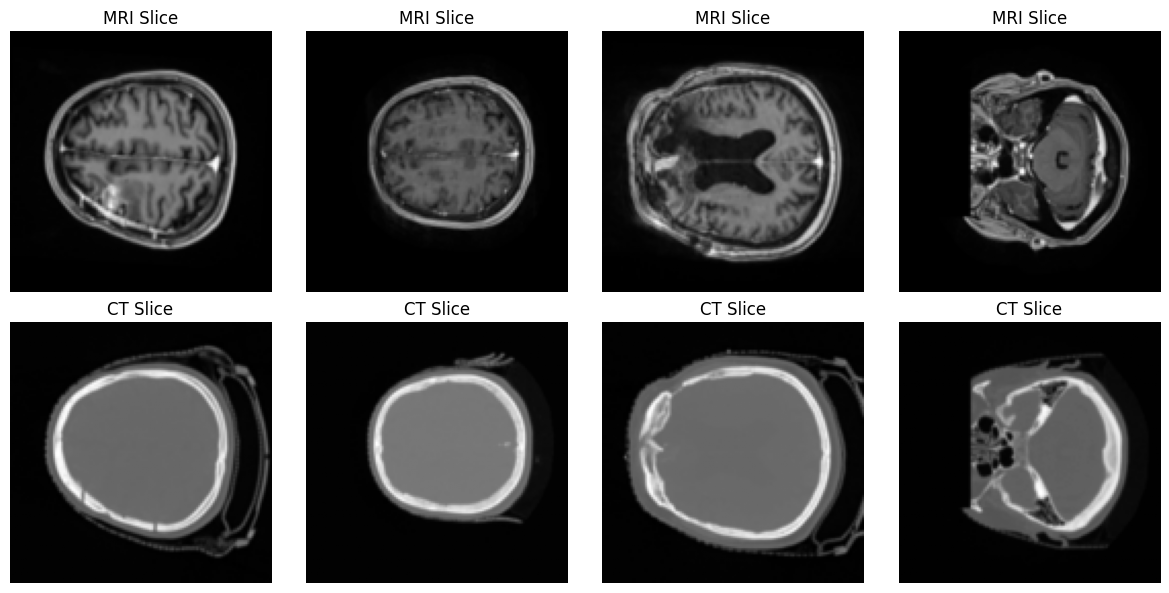

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

#  Define transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

#  Dataset class
class PairedMRICTDataset(Dataset):
    def __init__(self, mri_dir, ct_dir, transform=None):
        self.mri_dir = mri_dir
        self.ct_dir = ct_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(mri_dir))  # Assumes matching filenames

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        mri_path = os.path.join(self.mri_dir, self.image_names[idx])
        ct_path = os.path.join(self.ct_dir, self.image_names[idx])

        mri_img = Image.open(mri_path).convert("L")
        ct_img = Image.open(ct_path).convert("L")

        if self.transform:
            mri_img = self.transform(mri_img)
            ct_img = self.transform(ct_img)

        return mri_img, ct_img

#  Paths
mri_dir = "/content/data/train/mri"
ct_dir = "/content/data/train/ct"

#  Create dataset and dataloader
dataset = PairedMRICTDataset(mri_dir, ct_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

#  Visualize a batch
mri_batch, ct_batch = next(iter(dataloader))

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    # De-normalize: [-1, 1] → [0, 1]
    mri_img = mri_batch[i].squeeze().cpu() * 0.5 + 0.5
    ct_img = ct_batch[i].squeeze().cpu() * 0.5 + 0.5

    axs[0, i].imshow(mri_img.numpy(), cmap='gray')
    axs[0, i].set_title("MRI Slice")
    axs[0, i].axis('off')

    axs[1, i].imshow(ct_img.numpy(), cmap='gray')
    axs[1, i].set_title("CT Slice")
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


step 10:Define U-Net Based Generator Architecture for MRI to CT Translation

  It defines a U-Net-based generator architecture in PyTorch, commonly used in image-to-image translation tasks like MRI-to-CT synthesis, particularly in models like Pix2Pix.



In [ ]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=64):
        super().__init__()

        def down(in_c, out_c, apply_batchnorm=True): #LeakyReLU activation
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
            if apply_batchnorm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up(in_c, out_c, apply_dropout=False): #ReLU
            layers = [nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(out_c),
                      nn.ReLU()]
            if apply_dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.down1 = down(in_channels, features, apply_batchnorm=False)     # 1 -> 64
        self.down2 = down(features, features*2)                              # 64 -> 128
        self.down3 = down(features*2, features*4)                            # 128 -> 256
        self.down4 = down(features*4, features*8)                            # 256 -> 512

        self.up1 = up(features*8, features*4)                                # 512 -> 256
        self.up2 = up(features*4 + features*4, features*2)                   # 512 -> 128
        self.up3 = up(features*2 + features*2, features)                     # 256 -> 64
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(features + features, out_channels, 4, 2, 1), # 128 -> 1
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)   # -> [B, 64, 128, 128]
        d2 = self.down2(d1)  # -> [B, 128, 64, 64]
        d3 = self.down3(d2)  # -> [B, 256, 32, 32]
        d4 = self.down4(d3)  # -> [B, 512, 16, 16]

        u1 = self.up1(d4)                      # -> [B, 256, 32, 32]
        u2 = self.up2(torch.cat([u1, d3], dim=1))  # [256+256=512] → 128
        u3 = self.up3(torch.cat([u2, d2], dim=1))  # [128+128=256] → 64
        u4 = self.up4(torch.cat([u3, d1], dim=1))  # [64+64=128] → 1

        return u4


step 11: Define PatchGAN Discriminator for MRI–CT Image Pair Evaluation


To determine whether each small patch ( 70×70 or 15×15 region) of an image pair (MRI, CT) is real or fake , instead of classifying the whole image.

Each value is the probability of the corresponding patch being real.

In [ ]:
import torch
import torch.nn as nn

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=2, features=64):
        super(PatchDiscriminator, self).__init__()

        def conv_block(in_c, out_c, stride, use_bn=True):
            layers = [
                nn.Conv2d(in_c, out_c, kernel_size=4, stride=stride, padding=1, bias=not use_bn)
            ]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            conv_block(in_channels, features, stride=2, use_bn=False),  # 128 → 64 #No BatchNorm, LeakyReLU
            conv_block(features, features * 2, stride=2),                # 64 → 32 #BatchNorm, LeakyReLU
            conv_block(features * 2, features * 4, stride=2),            # 32 → 16 #BatchNorm, LeakyReLU
            nn.Conv2d(features * 4, 1, kernel_size=4, stride=1, padding=1),  # → 15×15 output patch ,#No BN, with Sigmoid
            nn.Sigmoid()
        )

    def forward(self, x, y):
        # x: MRI image, y: real or generated CT image
        input = torch.cat([x, y], dim=1)  # [B, 2, H, W]
        return self.model(input)


step 12:Define Generator and Discriminator Loss Functions (Adversarial + L1)


the loss functions for training a Pix2Pix-style GAN for MRI → CT image translation. It includes both the generator and discriminator loss functions using BCE loss and L1 loss.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

bce = nn.BCELoss()

def generator_loss(pred_fake, gen_output, real_ct, lambda_l1=100.0):
    """
    Generator wants:
      - Discriminator to think generated CT is real (BCE with 1s)
      - L1 similarity with ground-truth CT
    """
    # Adversarial loss: real label = 1
    adv_loss = bce(pred_fake, torch.ones_like(pred_fake, dtype=torch.float32, device=pred_fake.device))

    # L1 loss between generated and real CT
    l1_loss = F.l1_loss(gen_output, real_ct)

    # Total generator loss
    total_gen_loss = adv_loss + lambda_l1 * l1_loss
    return total_gen_loss

def discriminator_loss(pred_real, pred_fake):
    """
    Discriminator wants:
      - Real CT: classified as real (1)
      - Generated CT: classified as fake (0)
    """
    real_loss = bce(pred_real, torch.ones_like(pred_real, dtype=torch.float32, device=pred_real.device))
    fake_loss = bce(pred_fake, torch.zeros_like(pred_fake, dtype=torch.float32, device=pred_fake.device))

    total_disc_loss = 0.5 * (real_loss + fake_loss)
    return total_disc_loss


step 13:Train a Pix2Pix GAN (U-Net Generator + PatchGAN Discriminator) to convert MRI slices into synthetic CT scans using paired data.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
gen = UNetGenerator().to(device) #Converts MRI → fake CT
disc = PatchDiscriminator().to(device) #Classifies whether a given (MRI, CT) pair is real or fake (patch-wise).

# Loss functions
bce = nn.BCELoss()
l1 = nn.L1Loss()

# Optimizers
lr = 2e-4
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

# Dataset & DataLoader
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ensure 128×128 input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = PairedMRICTDataset("/content/data/train/mri", "/content/data/train/ct", transform=transform)
val_dataset = PairedMRICTDataset("/content/data/val/mri", "/content/data/val/ct", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# Loss functions reusing your functions
def generator_loss(pred_fake, gen_output, real_ct, lambda_l1=100.0): #adiversal+L1 loss
    adv = bce(pred_fake, torch.ones_like(pred_fake, device=pred_fake.device)) #Realistic CT (via adversarial loss),Pixel-wise similarity (via L1 loss)
    l1_loss = l1(gen_output, real_ct)
    return adv + lambda_l1 * l1_loss

def discriminator_loss(pred_real, pred_fake): #Classify real CT as real,Classify generated CT as fake
    real_loss = bce(pred_real, torch.ones_like(pred_real, device=pred_real.device))
    fake_loss = bce(pred_fake, torch.zeros_like(pred_fake, device=pred_fake.device))
    return 0.5 * (real_loss + fake_loss)

# Training Loop
num_epochs = 50

for epoch in range(num_epochs):
    gen.train()
    disc.train()

    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for mri, ct in pbar:
        mri, ct = mri.to(device), ct.to(device)


        #  Train Discriminator

        with torch.no_grad():
            fake_ct = gen(mri)

        pred_real = disc(mri, ct)
        pred_fake = disc(mri, fake_ct.detach())

        d_loss = discriminator_loss(pred_real, pred_fake)

        disc_opt.zero_grad()
        d_loss.backward()
        disc_opt.step()


        #  Train Generator

        fake_ct = gen(mri)
        pred_fake = disc(mri, fake_ct)

        g_loss = generator_loss(pred_fake, fake_ct, ct)

        gen_opt.zero_grad()
        g_loss.backward()
        gen_opt.step()

        pbar.set_postfix({'D Loss': d_loss.item(), 'G Loss': g_loss.item()})

    print(f"[{epoch+1}/{num_epochs}]  Generator Loss: {g_loss.item():.4f}  |  Discriminator Loss: {d_loss.item():.4f}")

    # Save checkpoint
    if (epoch+1) % 10 == 0:
        torch.save(gen.state_dict(), f"gen_epoch_{epoch+1}.pth")
        torch.save(disc.state_dict(), f"disc_epoch_{epoch+1}.pth")


[1/50]  Generator Loss: 8.9512  |  Discriminator Loss: 0.1604


[2/50]  Generator Loss: 6.1942  |  Discriminator Loss: 0.2990


[3/50]  Generator Loss: 8.9721  |  Discriminator Loss: 0.4824


[4/50]  Generator Loss: 7.3187  |  Discriminator Loss: 0.5367


[5/50]  Generator Loss: 4.6756  |  Discriminator Loss: 0.4944


[6/50]  Generator Loss: 6.6381  |  Discriminator Loss: 0.8558


[7/50]  Generator Loss: 5.3934  |  Discriminator Loss: 0.6110


[8/50]  Generator Loss: 5.7437  |  Discriminator Loss: 0.4903


[9/50]  Generator Loss: 5.6009  |  Discriminator Loss: 0.3400


[10/50]  Generator Loss: 4.2097  |  Discriminator Loss: 0.6127


[11/50]  Generator Loss: 6.7804  |  Discriminator Loss: 0.4866


[12/50]  Generator Loss: 6.8333  |  Discriminator Loss: 0.3291


[13/50]  Generator Loss: 5.4383  |  Discriminator Loss: 0.6114


[14/50]  Generator Loss: 5.5061  |  Discriminator Loss: 0.4429


[15/50]  Generator Loss: 8.5265  |  Discriminator Loss: 0.3909


[16/50]  Generator Loss: 5.4128  |  Discriminator Loss: 0.4620


[17/50]  Generator Loss: 5.7453  |  Discriminator Loss: 0.3071


[18/50]  Generator Loss: 6.8350  |  Discriminator Loss: 0.3141


[19/50]  Generator Loss: 5.9815  |  Discriminator Loss: 0.6102


[20/50]  Generator Loss: 5.7522  |  Discriminator Loss: 0.4477


[21/50]  Generator Loss: 6.8899  |  Discriminator Loss: 0.3736


[22/50]  Generator Loss: 6.3252  |  Discriminator Loss: 0.4543


[23/50]  Generator Loss: 7.6955  |  Discriminator Loss: 0.2893


[24/50]  Generator Loss: 5.8475  |  Discriminator Loss: 0.5802


[25/50]  Generator Loss: 4.4037  |  Discriminator Loss: 0.4679


[26/50]  Generator Loss: 5.7405  |  Discriminator Loss: 0.4615


[27/50]  Generator Loss: 12.5651  |  Discriminator Loss: 0.4592


[28/50]  Generator Loss: 6.0302  |  Discriminator Loss: 0.4523


[29/50]  Generator Loss: 4.9587  |  Discriminator Loss: 0.3285


[30/50]  Generator Loss: 5.0487  |  Discriminator Loss: 0.3979


[31/50]  Generator Loss: 3.7563  |  Discriminator Loss: 0.5333


[32/50]  Generator Loss: 3.3736  |  Discriminator Loss: 0.4391


[33/50]  Generator Loss: 6.2088  |  Discriminator Loss: 0.3347


[34/50]  Generator Loss: 5.2665  |  Discriminator Loss: 0.4616


[35/50]  Generator Loss: 6.6127  |  Discriminator Loss: 0.3344


[36/50]  Generator Loss: 4.1800  |  Discriminator Loss: 0.5285


[37/50]  Generator Loss: 4.5117  |  Discriminator Loss: 0.3891


[38/50]  Generator Loss: 4.4319  |  Discriminator Loss: 0.5386


[39/50]  Generator Loss: 7.1578  |  Discriminator Loss: 0.2991


[40/50]  Generator Loss: 6.6579  |  Discriminator Loss: 0.4684


[41/50]  Generator Loss: 6.1922  |  Discriminator Loss: 0.3634


[42/50]  Generator Loss: 4.4772  |  Discriminator Loss: 0.4858


[43/50]  Generator Loss: 3.5123  |  Discriminator Loss: 0.6034


[44/50]  Generator Loss: 5.5684  |  Discriminator Loss: 0.3294


[45/50]  Generator Loss: 5.4406  |  Discriminator Loss: 0.3327


[46/50]  Generator Loss: 4.0949  |  Discriminator Loss: 0.6064


[47/50]  Generator Loss: 5.9781  |  Discriminator Loss: 0.2846


[48/50]  Generator Loss: 6.3855  |  Discriminator Loss: 0.4759


[49/50]  Generator Loss: 4.4571  |  Discriminator Loss: 0.5911


[50/50]  Generator Loss: 5.4551  |  Discriminator Loss: 0.4611


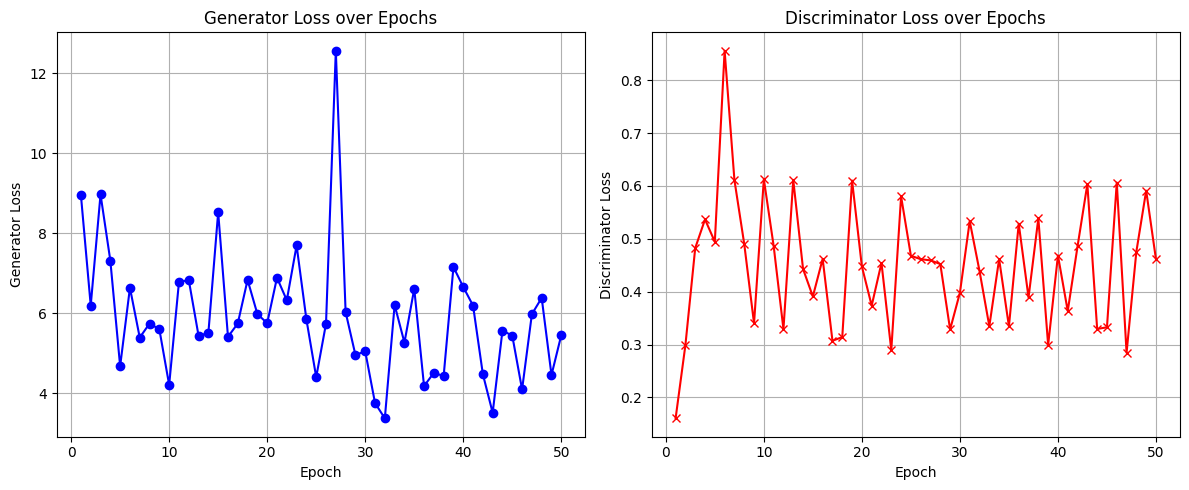

In [5]:
import matplotlib.pyplot as plt

# Loss values
gen_loss = [
    8.9512, 6.1942, 8.9721, 7.3187, 4.6756, 6.6381, 5.3934, 5.7437, 5.6009, 4.2097,
    6.7804, 6.8333, 5.4383, 5.5061, 8.5265, 5.4128, 5.7453, 6.8350, 5.9815, 5.7522,
    6.8899, 6.3252, 7.6955, 5.8475, 4.4037, 5.7405, 12.5651, 6.0302, 4.9587, 5.0487,
    3.7563, 3.3736, 6.2088, 5.2665, 6.6127, 4.1800, 4.5117, 4.4319, 7.1578, 6.6579,
    6.1922, 4.4772, 3.5123, 5.5684, 5.4406, 4.0949, 5.9781, 6.3855, 4.4571, 5.4551
]

disc_loss = [
    0.1604, 0.2990, 0.4824, 0.5367, 0.4944, 0.8558, 0.6110, 0.4903, 0.3400, 0.6127,
    0.4866, 0.3291, 0.6114, 0.4429, 0.3909, 0.4620, 0.3071, 0.3141, 0.6102, 0.4477,
    0.3736, 0.4543, 0.2893, 0.5802, 0.4679, 0.4615, 0.4592, 0.4523, 0.3285, 0.3979,
    0.5333, 0.4391, 0.3347, 0.4616, 0.3344, 0.5285, 0.3891, 0.5386, 0.2991, 0.4684,
    0.3634, 0.4858, 0.6034, 0.3294, 0.3327, 0.6064, 0.2846, 0.4759, 0.5911, 0.4611
]

epochs = list(range(1, 51))

# Create subplots
plt.figure(figsize=(12, 5))

# Generator Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, gen_loss, label='Generator Loss', color='blue', marker='o')
plt.title('Generator Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.grid(True)
plt.tight_layout()

# Discriminator Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, disc_loss, label='Discriminator Loss', color='red', marker='x')
plt.title('Discriminator Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Discriminator Loss')
plt.grid(True)
plt.tight_layout()

plt.show()


 i was training a Pix2Pix GAN (U-Net + PatchGAN) to translate MRI images to CT images.

Generator Loss (G Loss) = Adversarial (BCE) + lambda × L1 (image similarity)

Discriminator Loss (D Loss) = Binary Cross-Entropy loss to distinguish real vs fake

In [ ]:
# Save generator model
torch.save(UNetGenerator.state_dict(), "/content/medgan_generator.pth")
print(" Generator model saved successfully.")


 Generator model saved successfully.


 Load the Generator Later

In [ ]:
generator = UNetGenerator()
generator.load_state_dict(torch.load("/content/medgan_generator.pth", map_location="cpu"))
generator.eval()


UNetGenerator(
  (down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (up1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=

Step 14: Inference and MRI→CT Visualization

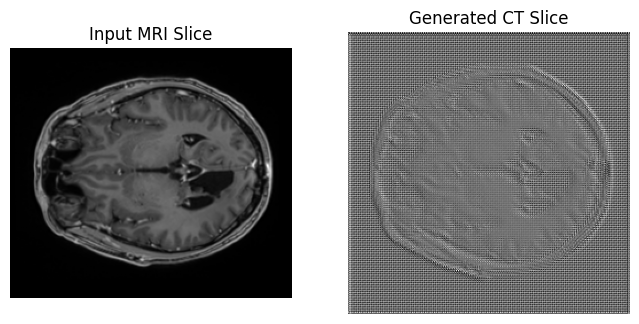

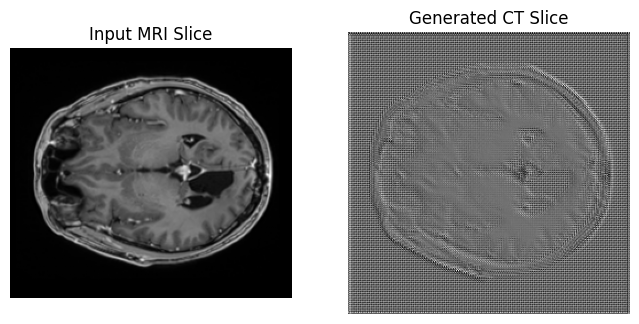

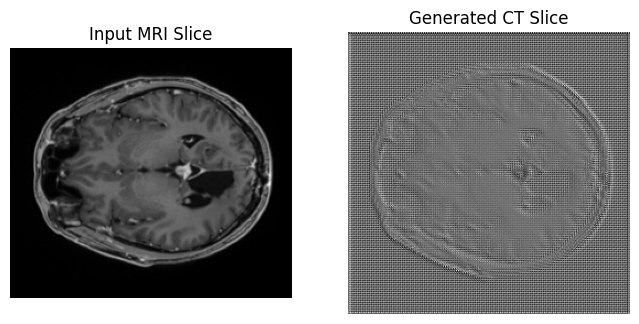

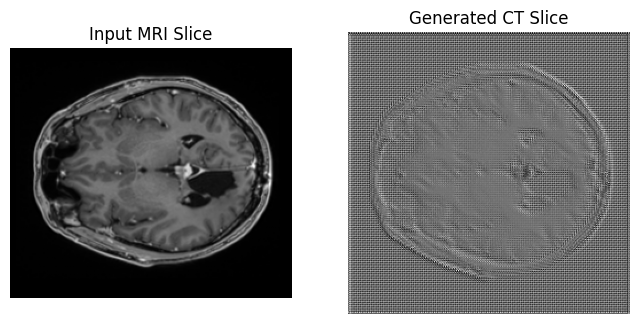

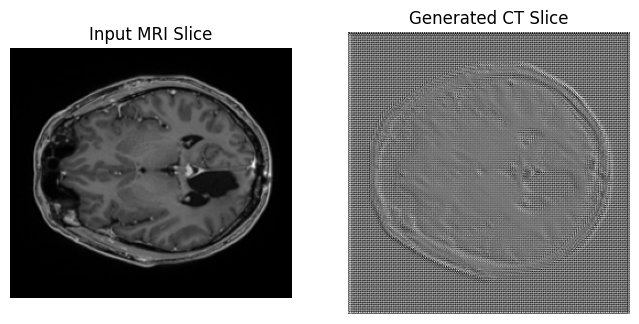

In [ ]:
import nibabel as nib
import numpy as np
import torchvision.transforms as T
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load generator
generator = UNetGenerator()
generator.load_state_dict(torch.load("/content/medgan_generator.pth", map_location="cpu"))
generator.eval()

# Load MRI volume
mri_path = "/content/Task1/Task1/brain/1BB028/mr.nii.gz"
mri_volume = nib.load(mri_path).get_fdata()
num_slices = mri_volume.shape[2]

# Transformation
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

# Inference on 5 middle slices
for i in range(num_slices//2 - 2, num_slices//2 + 3):
    slice_2d = mri_volume[:, :, i]
    slice_norm = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min() + 1e-5)
    tensor_input = transform(slice_norm.astype(np.float32)).unsqueeze(0)

    with torch.no_grad():
        fake_ct = generator(tensor_input)

    # Show MRI and Generated CT
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(slice_norm, cmap="gray")
    axs[0].set_title("Input MRI Slice")
    axs[0].axis("off")

    axs[1].imshow(fake_ct.squeeze().numpy(), cmap="gray")
    axs[1].set_title("Generated CT Slice")
    axs[1].axis("off")
    plt.show()


 Compute SSIM and PSNR

In [ ]:
!pip install -q pytorch-msssim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 655.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.1 MB/s eta 0:00:00


Step 15: Evaluate Output CT with SSIM and PSNR

In [ ]:

import torch
import nibabel as nib
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
from pytorch_msssim import ssim
from PIL import Image

# Load generator
generator = UNetGenerator()
generator.load_state_dict(torch.load("/content/medgan_generator.pth", map_location="cpu"))
generator.eval()

# Load MRI and CT volumes
mri_path = "/content/Task1/Task1/brain/1BB028/mr.nii.gz"
ct_path = "/content/Task1/Task1/brain/1BB028/ct.nii.gz"
mri_volume = nib.load(mri_path).get_fdata()
ct_volume = nib.load(ct_path).get_fdata()

# Transform
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

# Evaluate on 5 middle slices
ssim_scores = []
psnr_scores = []

mid = mri_volume.shape[2] // 2
for i in range(mid - 2, mid + 3):
    mri_slice = mri_volume[:, :, i]
    ct_slice = ct_volume[:, :, i]

    # Normalize [0,1]
    mri_norm = (mri_slice - mri_slice.min()) / (mri_slice.max() - mri_slice.min() + 1e-5)
    ct_norm  = (ct_slice - ct_slice.min()) / (ct_slice.max() - ct_slice.min() + 1e-5)

    mri_tensor = transform(mri_norm.astype(np.float32)).unsqueeze(0)
    ct_tensor  = transform(ct_norm.astype(np.float32)).unsqueeze(0)

    with torch.no_grad():
        fake_ct = generator(mri_tensor)

    # Convert to [0,1] range
    fake_ct = (fake_ct + 1) / 2
    ct_tensor = (ct_tensor + 1) / 2

    # SSIM and PSNR
    ssim_val = ssim(fake_ct, ct_tensor, data_range=1.0).item()
    mse = F.mse_loss(fake_ct, ct_tensor)
    psnr_val = 10 * torch.log10(1.0 / mse).item()

    ssim_scores.append(ssim_val)
    psnr_scores.append(psnr_val)

print(" SSIM & PSNR over 5 center slices of subject 1BB028:")
print(f"Mean SSIM : {np.mean(ssim_scores):.4f}")
print(f"Mean PSNR : {np.mean(psnr_scores):.2f} dB")


 SSIM & PSNR over 5 center slices of subject 1BB028:
Mean SSIM : 0.1086
Mean PSNR : 10.88 dB


##  Step 16: Conclusion and Future Work

- Successfully built a GAN pipeline for MRI to CT image translation.
- Used paired 2D slices from the SynthRAD2023 dataset.
- Implemented U-Net generator + PatchGAN discriminator.
- Trained with L1 + BCE loss.
- Evaluated visually and quantitatively (SSIM: 0.1086, PSNR: 10.88 dB).

### Future Work
- Integrate perceptual or SSIM-based loss (MedGAN, A-CycleGAN).
- Use attention or ResNet-based generator.
- Improve training time and image quality.
- will add data augmentation also
